In [9]:
# Author: Ernesto Rodríguez
# github.com/ernestorodg

###############################################################################
## Analyse Bezerra's dataset for intrusion detection using SVM
###############################################################################

In [10]:
import pandas as pd
import numpy as np
import sys

###############################################################################
## Define constants 
###############################################################################


# Random state for reproducibility
STATE = 0
np.random.seed(10)
# List of available attacks on the dataset


# Especific to the repository 
DATASET_DIRECTORY = r'../datasets/Dataset-bezerra-IoT-20200528T203526Z-001/Dataset-IoT/'
NETFLOW_DIRECTORY = r'NetFlow/'


# There are different csv files on the Dataset, with different types of data:

# Some meanings:
# MC: Media Center
# I: One hour of legitimate and malicious NetFlow data from profile.
# L: One hour of legitimate NetFlow data from profile.

MC = r'MC/'


# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets 
MC_I_FIRST = r'MC_I1.csv'

# MC_I_SECOND: Has infected data from Mirai botnets
MC_I_SECOND = r'MC_I2.csv'

# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
MC_I_THIRD = r'MC_I3.csv'

# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'



In [48]:
###############################################################################
## Load dataset
###############################################################################
df = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_FIRST)

# Add legitimate rows from MC_L
legitimate_frame = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_L)

for index in range (0, df.shape[0] // legitimate_frame.shape[0]):
    df = pd.concat([df, legitimate_frame])


# Sample the dataset if necessary
df = df.sample (frac = 0.1, replace = True, random_state = 0)

# We can see that this dataset has a temporal description.
# So it is not a good idea to randomly remove rows

# In this case we drop the index column, since pandas library creates an index
# automatically. 
df = df.drop(df.columns[0], axis=1)

# Also drop columns that has no significant data
df = df.drop(df.columns[14:], axis=1)

# Initial and end time is not a good feature for svm model
df = df.drop(['ts', 'te'], axis=1)

# Trying another drops to see relation between features and results
df = df.drop(['sa', 'sp', 'da', 'dp', 'fwd', 'stos'], axis=1)

# Counting number of null data
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]

# Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)


# if (df.Label.value_counts()[1] < df.Label.value_counts()[0]):
#     remove_n =  df.Label.value_counts()[0] - df.Label.value_counts()[1]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 0]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)
# else: 
#     remove_n =  df.Label.value_counts()[1] - df.Label.value_counts()[0]  # Number of rows to be removed   
#     print(remove_n)
#     df_to_be_dropped = df[df.Label == 1]
#     drop_indices = np.random.choice(df_to_be_dropped.index, remove_n, replace=False)
#     df = df.drop(drop_indices)


df

,Label,td,pr,flg,ipkt,ibyt
305711,1,0.0,TCP,....S.,1.0,40.0
462,0,279.0,TCP,.AP.SF,5.0,2288.0
117952,1,424.0,TCP,....S.,1.0,40.0
152315,1,0.0,TCP,....S.,1.0,40.0
359783,1,0.0,TCP,....S.,1.0,40.0
...,...,...,...,...,...,...
255777,1,0.0,TCP,....S.,1.0,40.0
243,0,37.0,TCP,.AP.SF,7.0,530.0
293,0,49.0,UDP,......,1.0,76.0
198,0,60668.0,TCP,.A.RSF,3.0,144.0


In [49]:
###############################################################################
## Slice the dataframe (usually the last column is the target)
###############################################################################

X = pd.DataFrame(df.iloc [:, 1:])

# Selecting other columns
# X = pd.concat([X, df.iloc[:, 2]], axis=1)

y = df.iloc [:, 0]
print('Number of non-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

# See Output, only available on jupyter-notebooks
# X

Number of non-attacks:  35913
Number of attacks:  36029


In [50]:
###############################################################################
## Split dataset into train and test sets if not using cross validation
###############################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 1/5,
                                                     random_state = STATE)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# X_train

In [51]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


####################################################################
# Treat categorical data on train set
####################################################################

cat_cols = X_train.columns[X_train.dtypes == 'O'] # Returns array with the columns that has Object types elements


categories = [
    X_train[column].unique() for column in X_train[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_train[cat_cols] = categorical_imputer.fit_transform(X_train[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)

X_train[cat_cols] = categorical_encoder.fit_transform(X_train[cat_cols])

# Scaling new numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_train[cat_cols] = numerical_imputer.fit_transform(X_train[cat_cols])

numerical_scaler = StandardScaler()
X_train[cat_cols] = numerical_scaler.fit_transform(X_train[cat_cols])



In [52]:
####################################################################
# Treat numerical data on train set
####################################################################

num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_train[num_cols] = numerical_imputer.fit_transform(X_train[num_cols])

numerical_scaler = StandardScaler()
X_train[num_cols] = numerical_scaler.fit_transform(X_train[num_cols])

# X_train

In [53]:
####################################################################
# Treat categorical data on test set (avoid leakeage)
####################################################################

cat_cols = X_test.columns[X_test.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X_test[column].unique() for column in X_test[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa


# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X_test[cat_cols] = categorical_imputer.fit_transform(X_test[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)

X_test[cat_cols] = categorical_encoder.fit_transform(X_test[cat_cols])

# Scaling new numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_test[cat_cols] = numerical_imputer.fit_transform(X_test[cat_cols])

numerical_scaler = StandardScaler()
X_test[cat_cols] = numerical_scaler.fit_transform(X_test[cat_cols])

In [54]:
####################################################################
# Treat numerical data on test set (avoid leakeage)
####################################################################

num_cols = X_test.columns[(X_test.dtypes == 'float64') | (X_test.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X_test[num_cols] = numerical_imputer.fit_transform(X_test[num_cols])

numerical_scaler = StandardScaler()
X_test[num_cols] = numerical_scaler.fit_transform(X_test[num_cols])

# X_test

In [61]:
###############################################################################
## Train the model using learning curve, using cross-validation
###############################################################################

import time
from sklearn.model_selection import learning_curve

# Measure time of training
start_time = time.time()

# Training the model with cross validation approach
train_sizes, train_scores, valid_scores = learning_curve(
                                            SVC(kernel="rbf", random_state=0, gamma=1, C=1), 
                                            X_train, 
                                            y_train, 
                                            cv=5,
                                            scoring='accuracy')
print("--- %s seconds ---" % (time.time() - start_time))


--- 117.82131171226501 seconds ---


In [68]:
valid_scores

array([[0.97133177, 0.97306924, 0.97324298, 0.97645526, 0.9753258 ],
       [0.97376423, 0.97558857, 0.97576231, 0.97880104, 0.97767159],
       [0.97376423, 0.97558857, 0.97576231, 0.97880104, 0.97767159],
       [0.97376423, 0.97558857, 0.97576231, 0.97880104, 0.97767159],
       [0.97376423, 0.97558857, 0.97576231, 0.97880104, 0.97767159]])

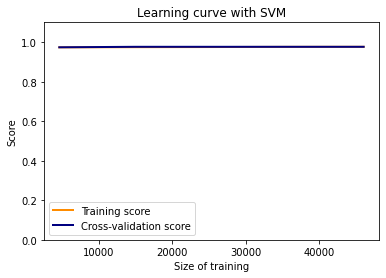

In [62]:
###############################################################################
## Plotting learning curve
###############################################################################
from matplotlib import pyplot as plt

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Learning curve with SVM")
plt.xlabel("Size of training")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(train_sizes, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.plot(train_sizes, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)

plt.legend(loc="best")
plt.show()


In [69]:
###############################################################################
## Training the model without cross-validation (simpler than the training above)
###############################################################################

# Assign the model to be used
svc = SVC(kernel="rbf", random_state=STATE, gamma=1, C=1)

# Measure time of this training
start_time = time.time()

# Training the model
model = svc.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.451737642288208 seconds ---


In [70]:
###############################################################################
## Obtain metrics from the trained model without cross-validation
###############################################################################

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix


# Predicting from the test slice
y_pred = model.predict(X_test)

# Precision == TP / (TP + FP)
print('Precision Score: ', precision_score(y_test, y_pred))

# Recall == TP / (TP + FN)
print('Recall Score: ', recall_score(y_test, y_pred))

# Accuracy 
print('Accuracy: \n', model.score(X_test, y_test))

# Multilabel Confusion Matrix: 
# [tn fp]
# [fn tp]
print(multilabel_confusion_matrix(y_test, y_pred, labels=[0, 1]))

Precision Score:  0.07046824292999536
Recall Score:  0.021294480246567667
Accuracy: 
 0.37514768225727985
[[[ 152 6986]
  [2005 5246]]

 [[5246 2005]
  [6986  152]]]


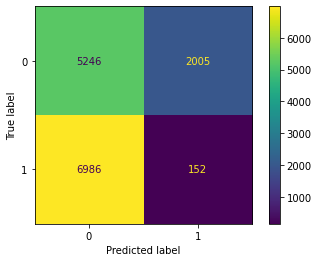

In [71]:
###############################################################################
## Plotting confusion matrix
###############################################################################
from sklearn.metrics import plot_confusion_matrix


plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP